In [ ]:
!git status


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from modules.models import KPPinn, create_dense_model
from modules.data import simulate_KP
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir("/content/drive/MyDrive/Trunk/PinnNew")
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


In [ ]:
k=6
c= 3.23
phi = 0


def phi_function(txy):
    offset =  +12
    ksi = txy[:, 1:2]-c*txy[:,0:1]+offset
    u = c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)+phi
    u = tf.where(tf.math.is_nan(u), 0., u)
    return u


def boundary_function(txy):
    return phi*tf.ones_like(txy[:, 1:2])

# x_start = 0
# length = 8*np.pi
x_start =  -50. #-10
length = 50.#10
time =  10

In [ ]:
def phi_function(txy):
    offset =  +12
    lamb = 0
    kappa = tf.sqrt(c/4) # c/2 = 2k^2
    ksi = txy[:, 1:2] + lamb*txy[:,2:3] - (c+2*lamb**2) * txy[:,0:1] + offset
    u = c / (2*tf.cosh(kappa*(ksi))**2)+phi
    u = tf.where(tf.math.is_nan(u), 0., u)
    return u

In [ ]:
(txy_eqn, u_eqn), (txy_init, u_init), (txy_boundary, u_boundary) = simulate_KP(50000, phi_function, boundary_function, time, x_start, length, x_start, length, random_seed = 42, dtype=tf.float32)

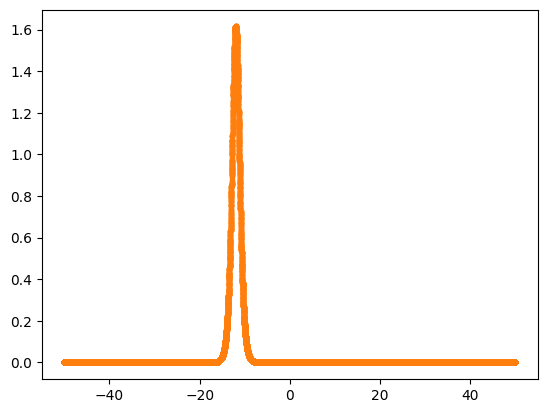

In [ ]:
plt.plot(txy_boundary[:,1:2],u_boundary,'.')

plt.plot( txy_init[:,1:2],phi_function(txy_init),'.')

inputs = [txy_eqn, txy_init, txy_boundary]
outputs = [phi_function(txy_eqn), u_eqn, u_init, u_boundary]


In [ ]:
backbone = create_dense_model([64, 128, 128,128, 64], activation='tanh', initializer='glorot_normal', \
    n_inputs=3, n_outputs=1)
pinn = KPPinn(backbone, k=6.) # coded strictly as KPII
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [ ]:
history = pinn.fit_custom(inputs, outputs, epochs = 50000, print_every = 500)

Epoch 0, Loss Residual: 0.0004, Loss Initial: 0.1281, Loss Boundary: 0.0948, MAE: 0.2953
Epoch 500, Loss Residual: 0.0001, Loss Initial: 0.0251, Loss Boundary: 0.0021, MAE: 0.0959
Epoch 1000, Loss Residual: 0.0004, Loss Initial: 0.0004, Loss Boundary: 0.0000, MAE: 0.0841
Epoch 1500, Loss Residual: 0.0001, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0851
Epoch 2000, Loss Residual: 0.0001, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0822
Epoch 2500, Loss Residual: 0.0001, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0818
Epoch 3000, Loss Residual: 0.0001, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0843
Epoch 3500, Loss Residual: 0.0001, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0809
Epoch 4000, Loss Residual: 0.0001, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0817
Epoch 4500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0825
Epoch 5000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE:

In [ ]:
plot_training_loss(history, y_scale='log')

NameError: ignored

In [ ]:
from matplotlib.gridspec import GridSpec
def plot_snapshots(timeList,num_test_samples = 200):
    x_flat = np.linspace(x_start, length, num_test_samples)
    y_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    y_flat = tf.convert_to_tensor(y_flat)
    t_flat = tf.convert_to_tensor(t_flat)

    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        x, y = np.meshgrid(x_flat, y_flat)
        txy = np.stack([np.full(x.flatten().shape, t_cs), x.flatten(), y.flatten()],axis=-1)


        fig = plt.figure(figsize=(7,4))
        gs = GridSpec(2, 5)
        plt.subplot(gs[0, :])

        u = pinn.backbone.predict(txy, batch_size=num_test_samples)
        u = u.reshape(x.shape)
        plt.pcolormesh(x, y, u)
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar(pad=0.05, aspect=10)
        cbar.set_label('u(t,x)')
        cbar.mappable.set_clim(-1, 2)
        fig = plt.figure()
        txy2 = np.stack([np.full(t_flat.shape, t_cs),  x_flat , np.full(t_flat.shape, -50)], axis=-1)

        u2 = pinn.backbone.predict(txy2, batch_size=num_test_samples)
        plt.plot(x_flat, u2, label = 'prediction at time {}'.format(t_cs))

    return

1/1 [==============================] - 0s 20ms/step


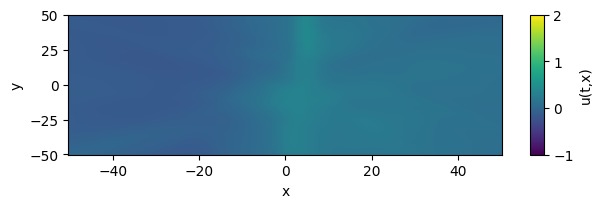

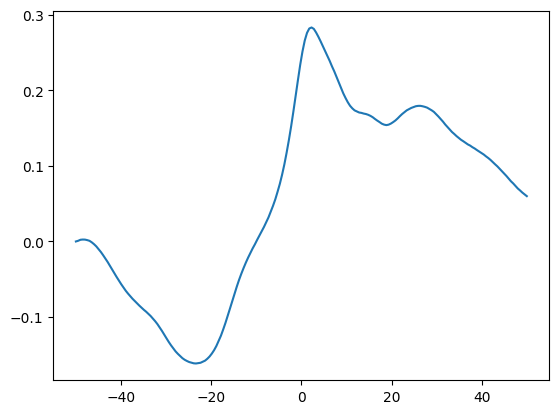

In [ ]:
plot_snapshots([10])

In [ ]:
! git status

Refresh index: 100% (72/72), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   PinnNew/KP.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
! git add PinnNew/KP.ipynb
! git commit -m "Updating plotting for KP solitons"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@13d8a82d9429.(none)')
